## Data Preprocessing

Import necessary libraries for data processing, visualization, and machine learning models

In [ ]:
import os
import re
import PIL
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import ensemble, tree, svm, model_selection,\
                    preprocessing, feature_extraction, metrics, base, pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

Load the COVID dataset from Google Drive and display the first and last few rows

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Covid Data.csv")
display(df)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


Rename the columns for easy access

In [ ]:
df = df.rename(columns={'HIPERTENSION': 'HYPERTENSION', 'CLASIFFICATION_FINAL': 'CLASSIFICATION', 'DATE_DIED': 'DIED'})

Check for duplicate rows and remove them from the dataset

In [ ]:
print(f"Number of duplicates: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of duplicates after: {df.duplicated().sum()}")

Number of duplicates: 812049
Number of duplicates after: 0


 Check for missing values in each column of the dataset

In [ ]:
df.isnull().sum()

,0
USMER,0
MEDICAL_UNIT,0
SEX,0
PATIENT_TYPE,0
DIED,0
INTUBED,0
PNEUMONIA,0
AGE,0
PREGNANT,0
DIABETES,0


Map or change the values of specific columns since actual missing data were given values like 99 and 98

In [ ]:
df['CLASSIFICATION'] = df['CLASSIFICATION'].apply(lambda x: 1 if 1 <= x <= 3 else (0 if 4 <= x <= 7 else x))
df['USMER'] = df['USMER'].map({1:1, 2:0})
df['SEX']= df['SEX'].map({1:1, 2:0})
df['DIED'] = df['DIED'].apply(lambda x: 0 if x == '9999-99-99' else 1)
df['ICU'] = df['ICU'].map({1:1, 2:0, 97:'sent home', 99:pd.NA})
df['INTUBED']= df['INTUBED'].map({1:1, 2:0, 97:'sent home', 99:pd.NA})
df['PREGNANT']= df['PREGNANT'].map({1:1, 2:0, 97:'male', 98:pd.NA})
df['PNEUMONIA']= df['PNEUMONIA'].map({1:1, 2:0, 99:pd.NA})
df['PATIENT_TYPE']= df['PATIENT_TYPE'].map({1:0, 2:1})

In [ ]:
mapping_dict = {1: 1, 2: 0, 98: pd.NA}

columns_to_map = [
    'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
    'TOBACCO', 'COPD', 'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'DIABETES']

for column in columns_to_map:
    df[column] = df[column].map(mapping_dict)

Displays the number of actual missing values after mapping

In [ ]:
df.isnull().sum()

,0
USMER,0
MEDICAL_UNIT,0
SEX,0
PATIENT_TYPE,0
DIED,0
INTUBED,5505
PNEUMONIA,7187
AGE,0
PREGNANT,1954
DIABETES,2840


Fill the missing values with appropriate data

In [ ]:
columns = [
    'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD',
    'ASTHMA', 'INMSUPR', 'HYPERTENSION', 'OTHER_DISEASE',
    'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']

for column in columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

<ipython-input-7-48e374fef4fa>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)
<ipython-input-7-48e374fef4fa>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column].fillna(df[column].mode()[0], inplace=True)


Displays the boxplot of numeric columns to show outliers

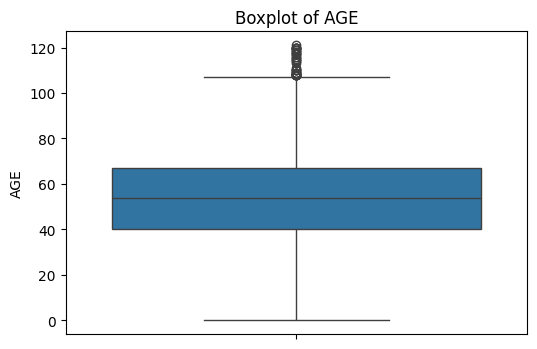

In [ ]:
numeric_columns = ['AGE']

plt.figure(figsize=(15,10))
for i, column in enumerate(numeric_columns, 1):
  plt.subplot(3, 3, i)
  sns.boxplot(df[column])
  plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

Handle outliers to reduce skewness

In [ ]:
df = df[df['AGE'] < df['AGE'].quantile(0.95)]

Do one-hot encoding for categorical columns

In [ ]:
df = pd.get_dummies(df, columns=['ICU', 'INTUBED', 'PREGNANT', 'MEDICAL_UNIT'], drop_first = False)

## Visualization Graphs

This pie chart shows that there is almost an equal distribution of the COVID and Non-COVID patients and that the model will unlikely have a bias towards the majority class.

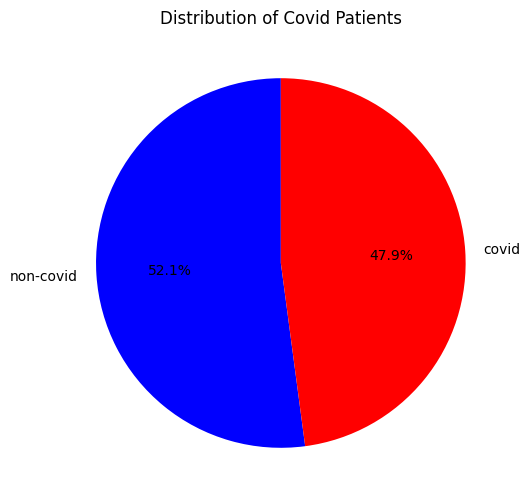

In [ ]:
constructive_counts = df['CLASSIFICATION'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(constructive_counts, labels=['non-covid', 'covid'], autopct='%1.1f%%', colors=['blue', 'red'], startangle=90)
plt.title('Distribution of Covid Patients')
plt.show()

This graph is provided by the CatBoost model to show the impact of each column value to the model output. The columns on the left are arranged based on their impact in increasing order.

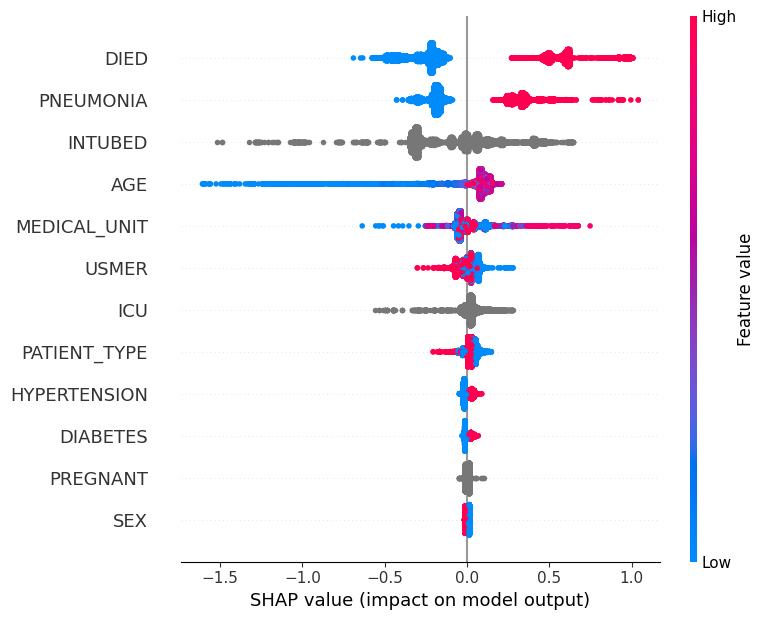

In [ ]:
import shap
import catboost
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Since the `DIED` column had the highest impact on the model output, this graph shows the relationship between the column and the target column

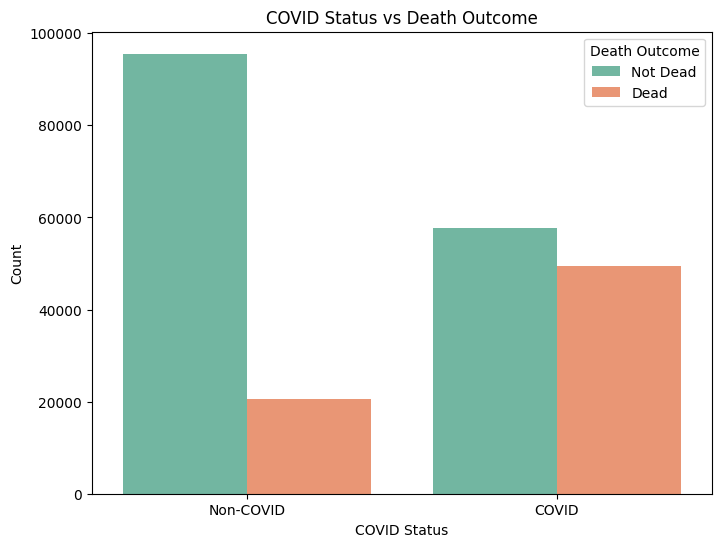

In [ ]:
plt.figure(figsize=(8,6))

sns.countplot(x='CLASSIFICATION', hue='DIED', data=df, palette='Set2')
plt.title('COVID Status vs Death Outcome')
plt.xlabel('COVID Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-COVID', 'COVID'])

plt.legend(title='Death Outcome', labels=['Not Dead', 'Dead'])

plt.show()


## Categorical Columns Distributions

This whole section shows the distribution of values in categorical columns. Overly undistributed columns shall be dropped to reduce bias.

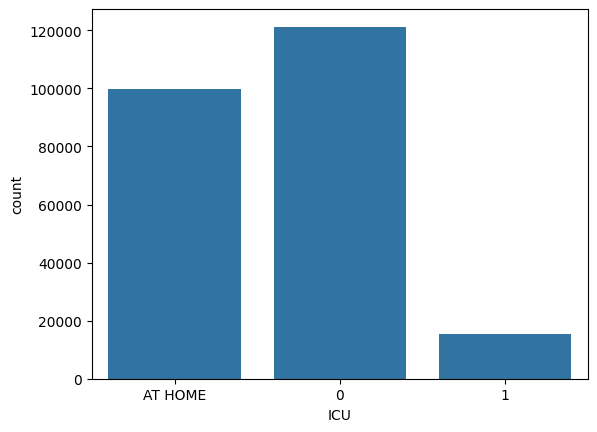

In [ ]:
sns.countplot(x = 'ICU', data = df)
plt.show()

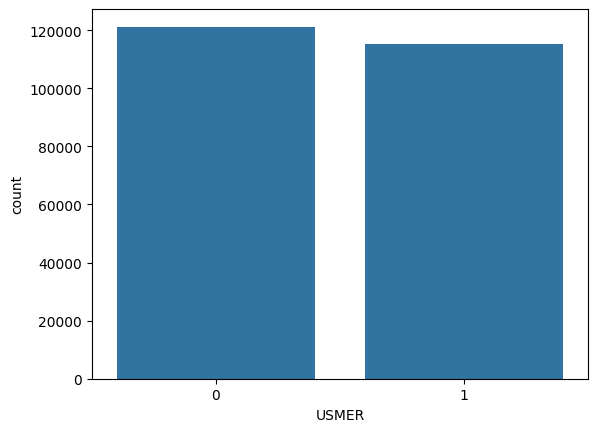

In [ ]:
sns.countplot(x = 'USMER', data = df)
plt.show()

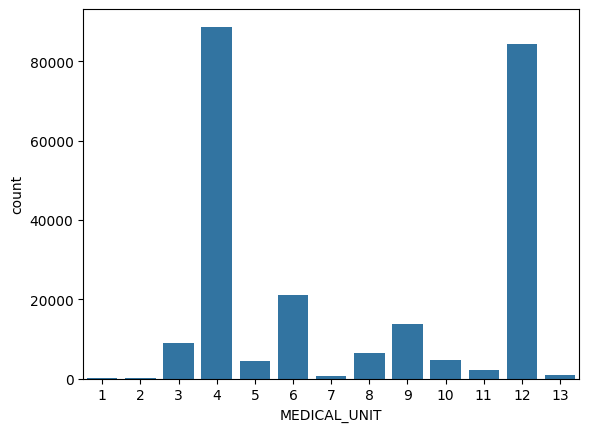

In [ ]:
sns.countplot(x = 'MEDICAL_UNIT', data = df)
plt.show()

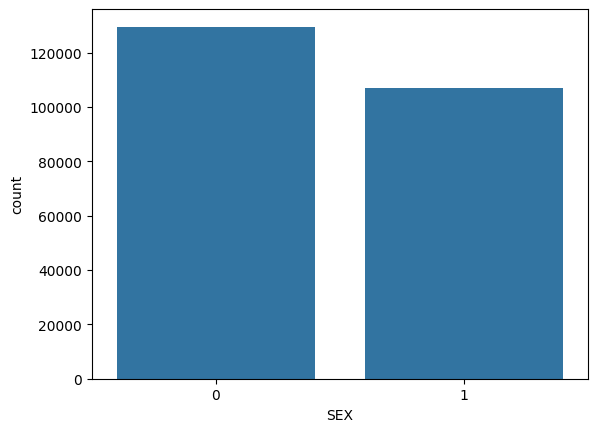

In [ ]:
sns.countplot(x = 'SEX', data = df)
plt.show()

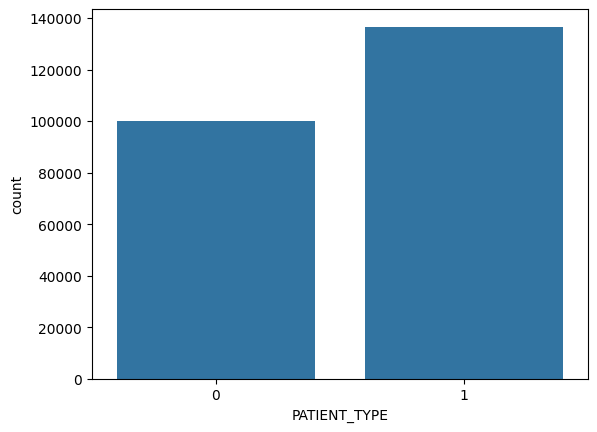

In [ ]:
sns.countplot(x = 'PATIENT_TYPE', data = df)
plt.show()

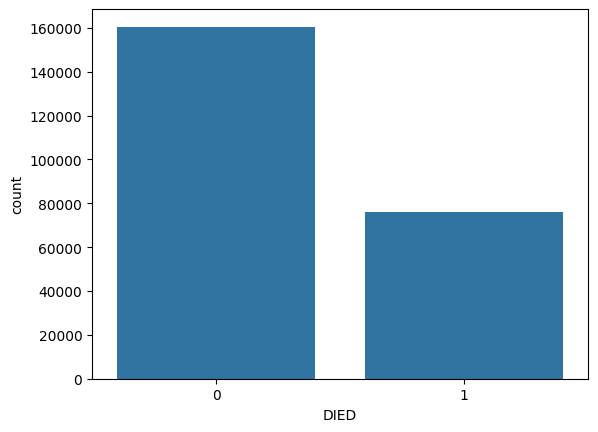

In [ ]:
sns.countplot(x = 'DIED', data = df)
plt.show()

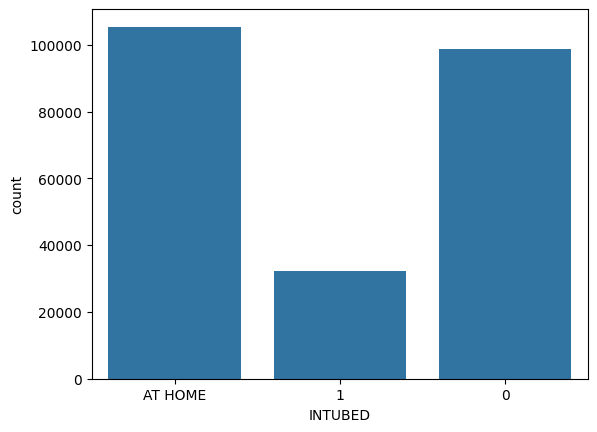

In [ ]:
sns.countplot(x = 'INTUBED', data = df)
plt.show()

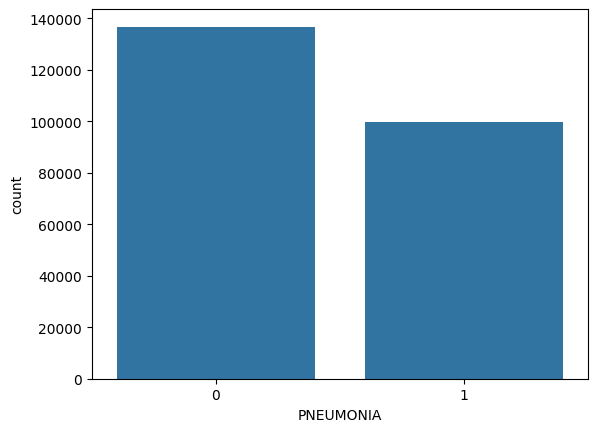

In [ ]:
sns.countplot(x = 'PNEUMONIA', data = df)
plt.show()

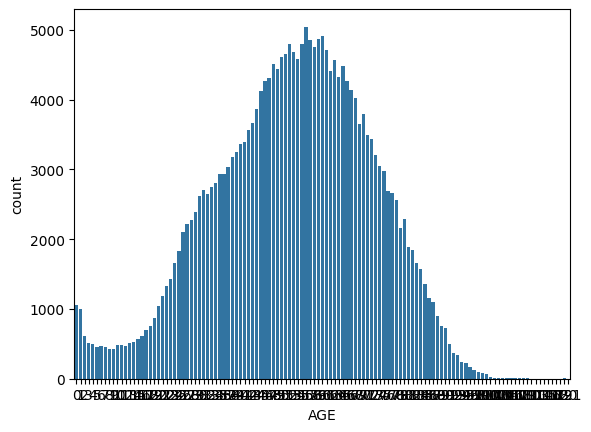

In [ ]:
sns.countplot(x = 'AGE', data = df)
plt.show()

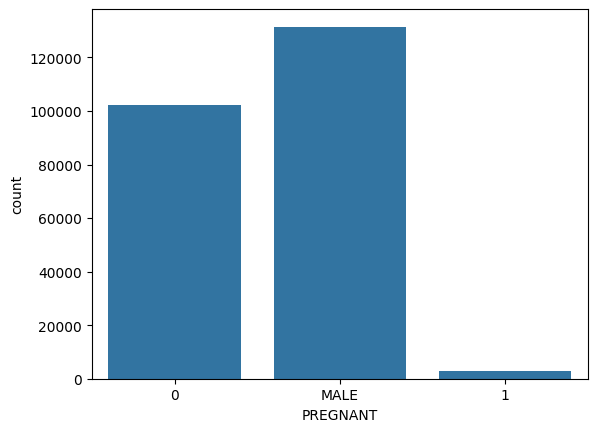

In [ ]:
sns.countplot(x = 'PREGNANT', data = df)
plt.show()

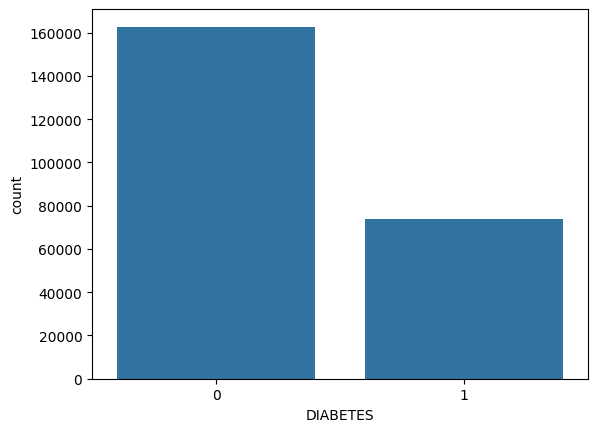

In [ ]:
sns.countplot(x = 'DIABETES', data = df)
plt.show()

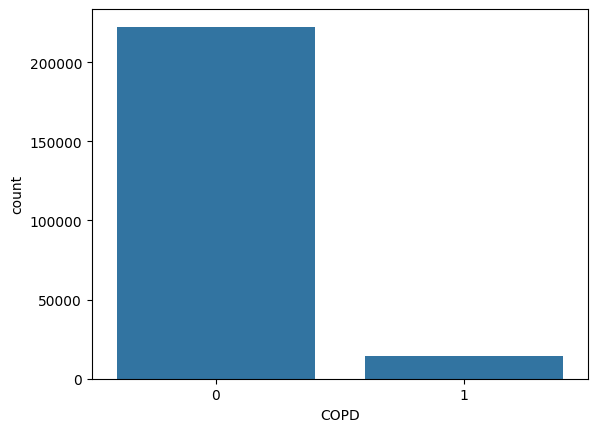

In [ ]:
sns.countplot(x = 'COPD', data = df)
plt.show()

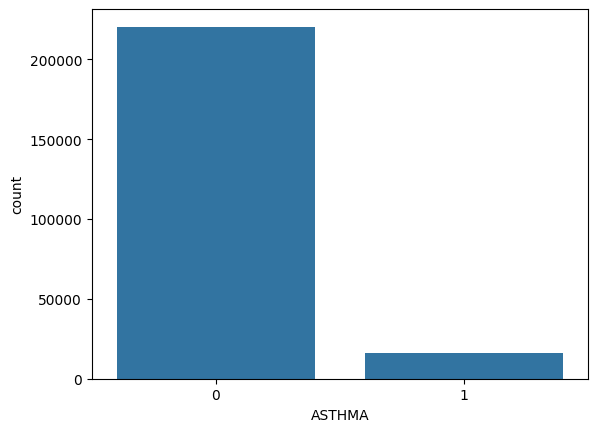

In [ ]:
sns.countplot(x = 'ASTHMA', data = df)
plt.show()

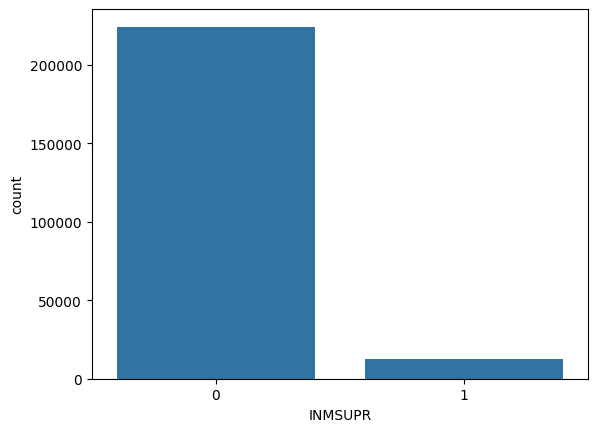

In [ ]:
sns.countplot(x = 'INMSUPR', data = df)
plt.show()

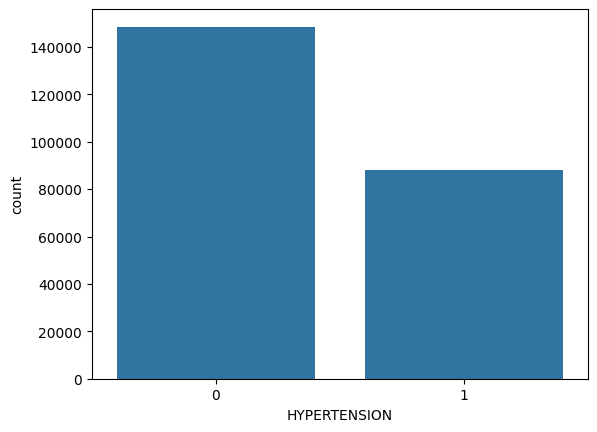

In [ ]:
sns.countplot(x = 'HYPERTENSION', data = df)
plt.show()

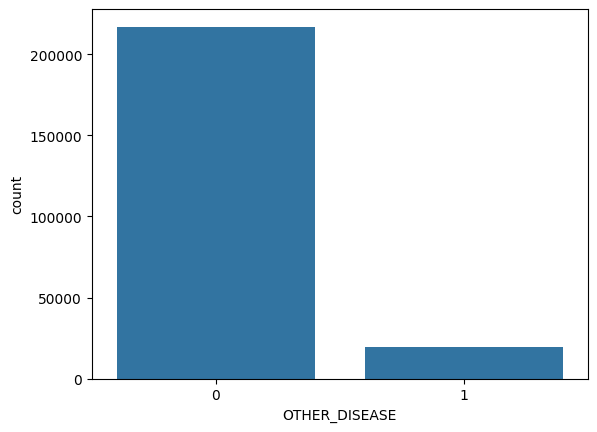

In [ ]:
sns.countplot(x = 'OTHER_DISEASE', data = df)
plt.show()

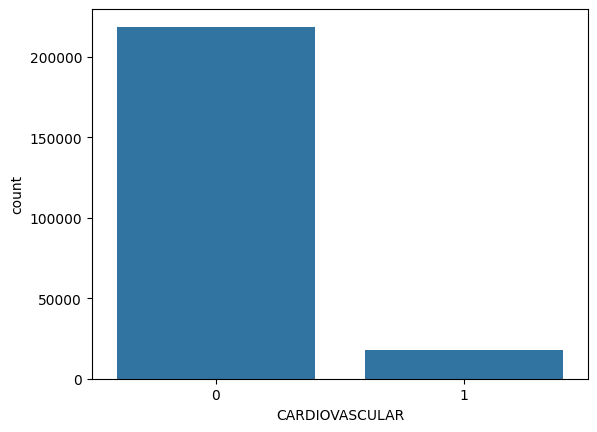

In [ ]:
sns.countplot(x = 'CARDIOVASCULAR', data = df)
plt.show()

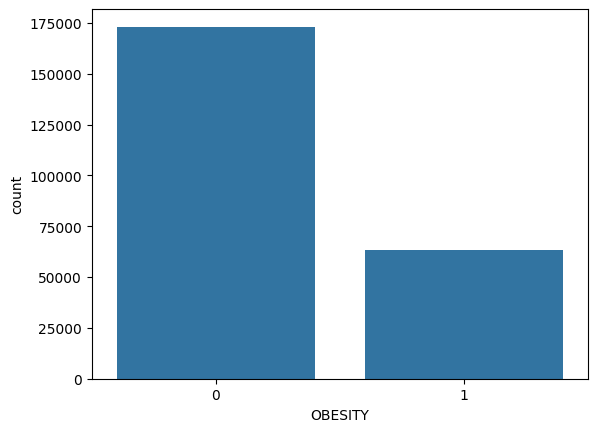

In [ ]:
sns.countplot(x = 'OBESITY', data = df)
plt.show()

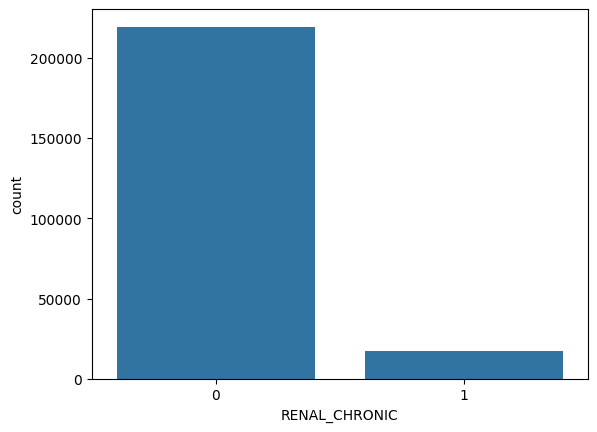

In [ ]:
sns.countplot(x = 'RENAL_CHRONIC', data = df)
plt.show()

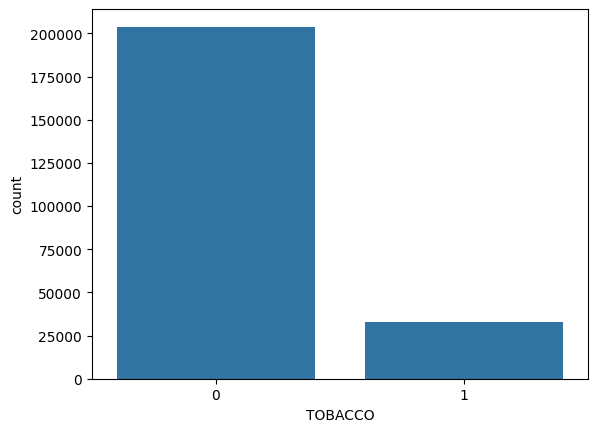

In [ ]:
sns.countplot(x = 'TOBACCO', data = df)
plt.show()

## Multiple Models

Drops the columns with unequally distributed values

In [ ]:
df.drop(['COPD', 'ASTHMA', 'INMSUPR', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO'], axis=1, inplace=True)

Assign columns into features and target

In [ ]:
X = df.drop('CLASSIFICATION', axis=1)
y = df['CLASSIFICATION']

**Logistic Regression**

In [ ]:
kfold = KFold(n_splits=20, shuffle=True, random_state=42)

In [ ]:
best_score = 0
best_model = None

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_score:
        best_score = accuracy
        best_model = model

print("Best Accuracy:", best_score)

Best Accuracy: 0.6638278798744958


In [ ]:
lr = LogisticRegression(solver='liblinear')
kfold = KFold(n_splits=10, shuffle=True, random_state=32)

In [ ]:
best_score = 0
best_model = None

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_score:
        best_score = accuracy
        best_model = model

print("Best Accuracy:", best_score)

Best Accuracy: 0.6607951234816907


**Random Forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=22)
kfold = KFold(n_splits=20, shuffle=True, random_state=22)

In [ ]:
best_score = 0
best_model = None

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestClassifier(n_estimators=100, random_state=22)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_score:
        best_score = accuracy
        best_model = model

print("Best Accuracy:", best_score)

Best Accuracy: 0.659345584939489


**Bernoulli Naive Bayes**

In [ ]:
from sklearn.naive_bayes import BernoulliNB
kf = KFold(n_splits=20, shuffle=True, random_state=42)
best_score = 0
best_model = None

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = BernoulliNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_score:
        best_score = accuracy
        best_model = model

print("Best Accuracy:", best_score)

Best Accuracy: 0.618018825638727


## CatBoost Model

In [ ]:
from catboost import CatBoostClassifier

kf = KFold(n_splits=10, shuffle=True, random_state=42)
catboost_accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(iterations=500,
                               learning_rate=0.1,
                               depth=6,
                               eval_metric='Accuracy',
                               verbose=50,
                               early_stopping_rounds=50)

    model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=50)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    catboost_accuracies.append(accuracy)

mean_accuracy = np.mean(catboost_accuracies)
print(f"CatBoost Average Accuracy with K-Fold: {mean_accuracy:.4f}")


0:	learn: 0.6520446	test: 0.6531756	best: 0.6531756 (0)	total: 170ms	remaining: 1m 24s
50:	learn: 0.6655860	test: 0.6632155	best: 0.6637085 (32)	total: 3.44s	remaining: 30.3s
100:	learn: 0.6676179	test: 0.6646497	best: 0.6655461 (72)	total: 7.75s	remaining: 30.6s
150:	learn: 0.6683948	test: 0.6667563	best: 0.6667563 (150)	total: 12.6s	remaining: 29.1s
200:	learn: 0.6693759	test: 0.6668460	best: 0.6670701 (154)	total: 15s	remaining: 22.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6670700551
bestIteration = 154

Shrink model to first 155 iterations.
0:	learn: 0.6520845	test: 0.6528170	best: 0.6528170 (0)	total: 42.9ms	remaining: 21.4s
50:	learn: 0.6657354	test: 0.6655013	best: 0.6658151 (48)	total: 2.11s	remaining: 18.6s
100:	learn: 0.6672693	test: 0.6667115	best: 0.6670252 (74)	total: 4.22s	remaining: 16.7s
150:	learn: 0.6684247	test: 0.6674286	best: 0.6674286 (147)	total: 8.47s	remaining: 19.6s
200:	learn: 0.6689626	test: 0.6670252	best: 0.6675631 (174)	total:

In [ ]:
from catboost import CatBoostClassifier

kf = KFold(n_splits=20, shuffle=True, random_state=42)
catboost_accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(iterations=500,
                               learning_rate=0.1,
                               depth=6,
                               eval_metric='Accuracy',
                               verbose=50,
                               early_stopping_rounds=50)

    model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=50)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    catboost_accuracies.append(accuracy)

mean_accuracy = np.mean(catboost_accuracies)
print(f"CatBoost Average Accuracy with K-Fold: {mean_accuracy:.4f}")


0:	learn: 0.6521741	test: 0.6518465	best: 0.6518465 (0)	total: 37.7ms	remaining: 18.8s
50:	learn: 0.6657199	test: 0.6634098	best: 0.6634098 (48)	total: 1.92s	remaining: 16.9s
100:	learn: 0.6674090	test: 0.6650233	best: 0.6652026 (67)	total: 3.81s	remaining: 15.1s
150:	learn: 0.6685319	test: 0.6652026	best: 0.6661886 (131)	total: 5.7s	remaining: 13.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6661885981
bestIteration = 131

Shrink model to first 132 iterations.
0:	learn: 0.6520373	test: 0.6544460	best: 0.6544460 (0)	total: 85.9ms	remaining: 42.8s
50:	learn: 0.6655689	test: 0.6626031	best: 0.6634098 (20)	total: 3.93s	remaining: 34.6s
100:	learn: 0.6671117	test: 0.6636787	best: 0.6641269 (88)	total: 5.8s	remaining: 22.9s
150:	learn: 0.6682535	test: 0.6654715	best: 0.6654715 (150)	total: 7.71s	remaining: 17.8s
200:	learn: 0.6690603	test: 0.6664575	best: 0.6664575 (200)	total: 9.6s	remaining: 14.3s
250:	learn: 0.6697492	test: 0.6664575	best: 0.6673539 (242)	total: 

In [ ]:
best_score = 0
best_model = None

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(iterations=500,
                               learning_rate=0.1,
                               depth=6,
                               eval_metric='Accuracy',
                               verbose=50,
                               early_stopping_rounds=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_score:
        best_score = accuracy
        best_model = model

print("Best Accuracy:", best_score)

0:	learn: 0.6520750	total: 90.7ms	remaining: 45.3s
50:	learn: 0.6652670	total: 4.81s	remaining: 42.4s
100:	learn: 0.6674798	total: 8.3s	remaining: 32.8s
150:	learn: 0.6683054	total: 10.2s	remaining: 23.6s
200:	learn: 0.6691972	total: 12.1s	remaining: 18.1s
250:	learn: 0.6698435	total: 14.1s	remaining: 13.9s
300:	learn: 0.6704616	total: 16s	remaining: 10.6s
350:	learn: 0.6709570	total: 17.9s	remaining: 7.59s
400:	learn: 0.6712071	total: 21.9s	remaining: 5.4s
450:	learn: 0.6715845	total: 23.9s	remaining: 2.59s
499:	learn: 0.6718818	total: 25.7s	remaining: 0us
0:	learn: 0.6523581	total: 44.1ms	remaining: 22s
50:	learn: 0.6657199	total: 1.93s	remaining: 17s
100:	learn: 0.6675788	total: 3.83s	remaining: 15.1s
150:	learn: 0.6684423	total: 5.72s	remaining: 13.2s
200:	learn: 0.6690084	total: 9.67s	remaining: 14.4s
250:	learn: 0.6694331	total: 11.6s	remaining: 11.5s
300:	learn: 0.6702116	total: 13.5s	remaining: 8.94s
350:	learn: 0.6707777	total: 15.4s	remaining: 6.56s
400:	learn: 0.6712637	tota

In [ ]:
best_score = 0
best_model = None

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = CatBoostClassifier(iterations=250,
                               learning_rate=0.1,
                               depth=6,
                               eval_metric='Accuracy',
                               verbose=50,
                               early_stopping_rounds=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_score:
        best_score = accuracy
        best_model = model

print("Best Accuracy:", best_score)

0:	learn: 0.6551374	total: 94.1ms	remaining: 23.4s
50:	learn: 0.6672245	total: 2.5s	remaining: 9.76s
100:	learn: 0.6705861	total: 4.75s	remaining: 7.01s
150:	learn: 0.6725334	total: 6.95s	remaining: 4.56s
200:	learn: 0.6740374	total: 9.19s	remaining: 2.24s
249:	learn: 0.6749787	total: 12.4s	remaining: 0us
0:	learn: 0.6571544	total: 60.4ms	remaining: 15s
50:	learn: 0.6674884	total: 3.41s	remaining: 13.3s
100:	learn: 0.6704716	total: 5.64s	remaining: 8.32s
150:	learn: 0.6718760	total: 7.92s	remaining: 5.19s
200:	learn: 0.6733850	total: 10.2s	remaining: 2.48s
249:	learn: 0.6745753	total: 12.5s	remaining: 0us
0:	learn: 0.6559790	total: 101ms	remaining: 25.1s
50:	learn: 0.6683251	total: 4.46s	remaining: 17.4s
100:	learn: 0.6708750	total: 6.68s	remaining: 9.85s
150:	learn: 0.6725135	total: 8.93s	remaining: 5.85s
200:	learn: 0.6741271	total: 11.2s	remaining: 2.73s
249:	learn: 0.6754618	total: 13.4s	remaining: 0us
0:	learn: 0.6577570	total: 91.1ms	remaining: 22.7s
50:	learn: 0.6679416	total: 4

In [ ]:
feature_importances = model.get_feature_importance()
for feature_name, importance in zip(X.columns, feature_importances):
    print(f"{feature_name}: {importance:.4f}")

USMER: 3.3062
SEX: 0.1832
PATIENT_TYPE: 5.0484
DIED: 29.3060
PNEUMONIA: 9.6952
AGE: 10.6284
DIABETES: 0.7378
HYPERTENSION: 0.5681
ICU_0: 7.7176
ICU_1: 0.6426
ICU_sent home: 1.4885
INTUBED_0: 1.1786
INTUBED_1: 3.7592
INTUBED_sent home: 14.0318
PREGNANT_0: 0.2363
PREGNANT_1: 0.1602
PREGNANT_male: 0.1527
MEDICAL_UNIT_1: 0.0000
MEDICAL_UNIT_2: 0.2148
MEDICAL_UNIT_3: 0.6178
MEDICAL_UNIT_4: 4.6074
MEDICAL_UNIT_5: 0.1752
MEDICAL_UNIT_6: 0.6468
MEDICAL_UNIT_7: 0.0884
MEDICAL_UNIT_8: 0.7042
MEDICAL_UNIT_9: 1.3083
MEDICAL_UNIT_10: 1.1992
MEDICAL_UNIT_11: 0.8570
MEDICAL_UNIT_12: 0.5975
MEDICAL_UNIT_13: 0.1425


## User Input 1

If the patient died and was in a critical condition, the patient is most likely a COVID patient

In [ ]:
expected_columns = [
    "USMER",
    "SEX",
    "PATIENT_TYPE",
    "DIED",
    "PNEUMONIA",
    "AGE",
    "DIABETES",
    "HYPERTENSION",
    "ICU_0", "ICU_1", "ICU_sent home",
    "INTUBED_0", "INTUBED_1", "INTUBED_sent home",
    "PREGNANT_0", "PREGNANT_1", "PREGNANT_male",
    "MEDICAL_UNIT_1", "MEDICAL_UNIT_2", "MEDICAL_UNIT_3", "MEDICAL_UNIT_4", "MEDICAL_UNIT_5", "MEDICAL_UNIT_6",
    "MEDICAL_UNIT_7", "MEDICAL_UNIT_8", "MEDICAL_UNIT_9", "MEDICAL_UNIT_10",
    "MEDICAL_UNIT_11", "MEDICAL_UNIT_12", "MEDICAL_UNIT_13"
    ]

def one_hot_encode_fixed(input_data, expected_columns):
    # Use pd.get_dummies to one-hot encode categorical columns
    input_encoded = pd.get_dummies(input_data, columns=["SEX", "USMER", "PATIENT_TYPE", "DIED", "PNEUMONIA", "DIABETES",
                                                        "HYPERTENSION", "ICU", "INTUBED", "PREGNANT", "MEDICAL_UNIT"],
                                   drop_first=False, dummy_na=False)

    for col in expected_columns:
        if col not in input_encoded:
            input_encoded[col] = 0

    input_encoded = input_encoded[expected_columns]

    return input_encoded

def predict_user_input():
    input_data = {}

    input_data['USMER'] = int(input("Is the patient in the USMER network? (0 for No, 1 for Yes): "))
    input_data['SEX'] = int(input("Enter sex (0 for male, 1 for female): "))
    input_data['PATIENT_TYPE'] = int(input("Was the patient admitted? (0 for sent home, 1 for hospitalized): "))
    input_data['DIED'] = int(input("Did the patient die? (0 for No, 1 for Yes): "))
    input_data['PNEUMONIA'] = int(input("Did the patient have pneumonia? (0 for No, 1 for Yes): "))
    input_data['AGE'] = float(input("Enter the patient's age: "))
    input_data['DIABETES'] = int(input("Does the patient have diabetes? (0 for No, 1 for Yes): "))
    input_data['HYPERTENSION'] = int(input("Does the patient have hypertension? (0 for No, 1 for Yes): "))
    if input_data['PATIENT_TYPE'] == 1:
        input_data['ICU'] = int(input("Was the patient admitted to ICU? (0 for No, 1 for Yes): "))
        input_data['INTUBED'] = int(input("Was the patient intubated? (0 for No, 1 for Yes): "))
    else:
      input_data['ICU'] = 'sent home'
      input_data['INTUBED'] = 'sent home'

    if input_data['SEX'] == 1:
        input_data['PREGNANT'] = int(input("Is the patient pregnant? (0 for No, 1 for Yes): "))
    else:
        input_data['PREGNANT'] = 'male'
    input_data['MEDICAL_UNIT'] = input("Enter medical unit (1-13):")

    input_data = pd.DataFrame([input_data])

    input_encoded = one_hot_encode_fixed(
        input_data, expected_columns
    )
    prediction = best_model.predict(input_encoded)
    return input_data, "Non-COVID Patient" if prediction[0] == 0 else "COVID Patient"

input_data, prediction = predict_user_input()

print(input_data)
print(prediction)


Is the patient in the USMER network? (0 for No, 1 for Yes): 1
Enter sex (0 for male, 1 for female): 0
Was the patient admitted? (0 for sent home, 1 for hospitalized): 1
Did the patient die? (0 for No, 1 for Yes): 1
Did the patient have pneumonia? (0 for No, 1 for Yes): 1
Enter the patient's age: 56
Does the patient have diabetes? (0 for No, 1 for Yes): 1
Does the patient have hypertension? (0 for No, 1 for Yes): 1
Was the patient admitted to ICU? (0 for No, 1 for Yes): 1
Was the patient intubated? (0 for No, 1 for Yes): 1
Enter medical unit (1-13):3
   USMER  SEX  PATIENT_TYPE  DIED  PNEUMONIA   AGE  DIABETES  HYPERTENSION  \
0      1    0             1     1          1  56.0         1             1   

   ICU  INTUBED PREGNANT MEDICAL_UNIT  
0    1        1     male            3  
COVID Patient


## User Input 2

If the patient is alive and is not in critical condition, they're most likely a Non-COVID patient

In [ ]:
expected_columns = [
    "USMER",
    "SEX",
    "PATIENT_TYPE",
    "DIED",
    "PNEUMONIA",
    "AGE",
    "DIABETES",
    "HYPERTENSION",
    "ICU_0", "ICU_1", "ICU_sent home",
    "INTUBED_0", "INTUBED_1", "INTUBED_sent home",
    "PREGNANT_0", "PREGNANT_1", "PREGNANT_male",
    "MEDICAL_UNIT_1", "MEDICAL_UNIT_2", "MEDICAL_UNIT_3", "MEDICAL_UNIT_4", "MEDICAL_UNIT_5", "MEDICAL_UNIT_6",
    "MEDICAL_UNIT_7", "MEDICAL_UNIT_8", "MEDICAL_UNIT_9", "MEDICAL_UNIT_10",
    "MEDICAL_UNIT_11", "MEDICAL_UNIT_12", "MEDICAL_UNIT_13"
    ]

def one_hot_encode_fixed(input_data, expected_columns):
    # Use pd.get_dummies to one-hot encode categorical columns
    input_encoded = pd.get_dummies(input_data, columns=["SEX", "USMER", "PATIENT_TYPE", "DIED", "PNEUMONIA", "DIABETES",
                                                        "HYPERTENSION", "ICU", "INTUBED", "PREGNANT", "MEDICAL_UNIT"],
                                   drop_first=False, dummy_na=False)

    for col in expected_columns:
        if col not in input_encoded:
            input_encoded[col] = 0

    input_encoded = input_encoded[expected_columns]

    return input_encoded

def predict_user_input():
    input_data = {}

    input_data['USMER'] = int(input("Is the patient in the USMER network? (0 for No, 1 for Yes): "))
    input_data['SEX'] = int(input("Enter sex (0 for male, 1 for female): "))
    input_data['PATIENT_TYPE'] = int(input("Was the patient admitted? (0 for sent home, 1 for hospitalized): "))
    input_data['DIED'] = int(input("Did the patient die? (0 for No, 1 for Yes): "))
    input_data['PNEUMONIA'] = int(input("Did the patient have pneumonia? (0 for No, 1 for Yes): "))
    input_data['AGE'] = float(input("Enter the patient's age: "))
    input_data['DIABETES'] = int(input("Does the patient have diabetes? (0 for No, 1 for Yes): "))
    input_data['HYPERTENSION'] = int(input("Does the patient have hypertension? (0 for No, 1 for Yes): "))
    if input_data['PATIENT_TYPE'] == 1:
        input_data['ICU'] = int(input("Was the patient admitted to ICU? (0 for No, 1 for Yes): "))
        input_data['INTUBED'] = int(input("Was the patient intubated? (0 for No, 1 for Yes): "))
    else:
      input_data['ICU'] = 'sent home'
      input_data['INTUBED'] = 'sent home'

    if input_data['SEX'] == 1:
        input_data['PREGNANT'] = int(input("Is the patient pregnant? (0 for No, 1 for Yes): "))
    else:
        input_data['PREGNANT'] = 'male'
    input_data['MEDICAL_UNIT'] = input("Enter medical unit (1-13):")

    input_data = pd.DataFrame([input_data])

    input_encoded = one_hot_encode_fixed(
        input_data, expected_columns
    )
    prediction = best_model.predict(input_encoded)
    return input_data, "Non-COVID Patient" if prediction[0] == 0 else "COVID Patient"

input_data, prediction = predict_user_input()

print(input_data)
print(prediction)


Is the patient in the USMER network? (0 for No, 1 for Yes): 0
Enter sex (0 for male, 1 for female): 0
Was the patient admitted? (0 for sent home, 1 for hospitalized): 0
Did the patient die? (0 for No, 1 for Yes): 0
Did the patient have pneumonia? (0 for No, 1 for Yes): 1
Enter the patient's age: 76
Does the patient have diabetes? (0 for No, 1 for Yes): 0
Does the patient have hypertension? (0 for No, 1 for Yes): 1
Enter medical unit (1-13):4
   USMER  SEX  PATIENT_TYPE  DIED  PNEUMONIA   AGE  DIABETES  HYPERTENSION  \
0      0    0             0     0          1  76.0         0             1   

         ICU    INTUBED PREGNANT MEDICAL_UNIT  
0  sent home  sent home     male            4  
Non-COVID Patient


## User Input 3

If the patient died but wasn't in a critical condition, they're most likely a Non-COVID patient.

In [ ]:
expected_columns = [
    "USMER",
    "SEX",
    "PATIENT_TYPE",
    "DIED",
    "PNEUMONIA",
    "AGE",
    "DIABETES",
    "HYPERTENSION",
    "ICU_0", "ICU_1", "ICU_sent home",
    "INTUBED_0", "INTUBED_1", "INTUBED_sent home",
    "PREGNANT_0", "PREGNANT_1", "PREGNANT_male",
    "MEDICAL_UNIT_1", "MEDICAL_UNIT_2", "MEDICAL_UNIT_3", "MEDICAL_UNIT_4", "MEDICAL_UNIT_5", "MEDICAL_UNIT_6",
    "MEDICAL_UNIT_7", "MEDICAL_UNIT_8", "MEDICAL_UNIT_9", "MEDICAL_UNIT_10",
    "MEDICAL_UNIT_11", "MEDICAL_UNIT_12", "MEDICAL_UNIT_13"
    ]

def one_hot_encode_fixed(input_data, expected_columns):
    # Use pd.get_dummies to one-hot encode categorical columns
    input_encoded = pd.get_dummies(input_data, columns=["SEX", "USMER", "PATIENT_TYPE", "DIED", "PNEUMONIA", "DIABETES",
                                                        "HYPERTENSION", "ICU", "INTUBED", "PREGNANT", "MEDICAL_UNIT"],
                                   drop_first=False, dummy_na=False)

    for col in expected_columns:
        if col not in input_encoded:
            input_encoded[col] = 0

    input_encoded = input_encoded[expected_columns]

    return input_encoded

def predict_user_input():
    input_data = {}

    input_data['USMER'] = int(input("Is the patient in the USMER network? (0 for No, 1 for Yes): "))
    input_data['SEX'] = int(input("Enter sex (0 for male, 1 for female): "))
    input_data['PATIENT_TYPE'] = int(input("Was the patient admitted? (0 for sent home, 1 for hospitalized): "))
    input_data['DIED'] = int(input("Did the patient die? (0 for No, 1 for Yes): "))
    input_data['PNEUMONIA'] = int(input("Did the patient have pneumonia? (0 for No, 1 for Yes): "))
    input_data['AGE'] = float(input("Enter the patient's age: "))
    input_data['DIABETES'] = int(input("Does the patient have diabetes? (0 for No, 1 for Yes): "))
    input_data['HYPERTENSION'] = int(input("Does the patient have hypertension? (0 for No, 1 for Yes): "))
    if input_data['PATIENT_TYPE'] == 1:
        input_data['ICU'] = int(input("Was the patient admitted to ICU? (0 for No, 1 for Yes): "))
        input_data['INTUBED'] = int(input("Was the patient intubated? (0 for No, 1 for Yes): "))
    else:
      input_data['ICU'] = 'sent home'
      input_data['INTUBED'] = 'sent home'

    if input_data['SEX'] == 1:
        input_data['PREGNANT'] = int(input("Is the patient pregnant? (0 for No, 1 for Yes): "))
    else:
        input_data['PREGNANT'] = 'male'
    input_data['MEDICAL_UNIT'] = input("Enter medical unit (1-13):")

    input_data = pd.DataFrame([input_data])

    input_encoded = one_hot_encode_fixed(
        input_data, expected_columns
    )
    prediction = best_model.predict(input_encoded)
    return input_data, "Non-COVID Patient" if prediction[0] == 0 else "COVID Patient"

input_data, prediction = predict_user_input()

print(input_data)
print(prediction)


Is the patient in the USMER network? (0 for No, 1 for Yes): 0
Enter sex (0 for male, 1 for female): 0
Was the patient admitted? (0 for sent home, 1 for hospitalized): 0
Did the patient die? (0 for No, 1 for Yes): 1
Did the patient have pneumonia? (0 for No, 1 for Yes): 0
Enter the patient's age: 87
Does the patient have diabetes? (0 for No, 1 for Yes): 0
Does the patient have hypertension? (0 for No, 1 for Yes): 0
Enter medical unit (1-13):3
   USMER  SEX  PATIENT_TYPE  DIED  PNEUMONIA   AGE  DIABETES  HYPERTENSION  \
0      0    0             0     1          0  87.0         0             0   

         ICU    INTUBED PREGNANT MEDICAL_UNIT  
0  sent home  sent home     male            3  
Non-COVID Patient


## User Input 4

If the patient is alive and is in a critical condition, they're most likely a COVID patient.

In [ ]:
expected_columns = [
    "USMER",
    "SEX",
    "PATIENT_TYPE",
    "DIED",
    "PNEUMONIA",
    "AGE",
    "DIABETES",
    "HYPERTENSION",
    "ICU_0", "ICU_1", "ICU_sent home",
    "INTUBED_0", "INTUBED_1", "INTUBED_sent home",
    "PREGNANT_0", "PREGNANT_1", "PREGNANT_male",
    "MEDICAL_UNIT_1", "MEDICAL_UNIT_2", "MEDICAL_UNIT_3", "MEDICAL_UNIT_4", "MEDICAL_UNIT_5", "MEDICAL_UNIT_6",
    "MEDICAL_UNIT_7", "MEDICAL_UNIT_8", "MEDICAL_UNIT_9", "MEDICAL_UNIT_10",
    "MEDICAL_UNIT_11", "MEDICAL_UNIT_12", "MEDICAL_UNIT_13"
    ]

def one_hot_encode_fixed(input_data, expected_columns):
    # Use pd.get_dummies to one-hot encode categorical columns
    input_encoded = pd.get_dummies(input_data, columns=["SEX", "USMER", "PATIENT_TYPE", "DIED", "PNEUMONIA", "DIABETES",
                                                        "HYPERTENSION", "ICU", "INTUBED", "PREGNANT", "MEDICAL_UNIT"],
                                   drop_first=False, dummy_na=False)

    for col in expected_columns:
        if col not in input_encoded:
            input_encoded[col] = 0

    input_encoded = input_encoded[expected_columns]

    return input_encoded

def predict_user_input():
    input_data = {}

    input_data['USMER'] = int(input("Is the patient in the USMER network? (0 for No, 1 for Yes): "))
    input_data['SEX'] = int(input("Enter sex (0 for male, 1 for female): "))
    input_data['PATIENT_TYPE'] = int(input("Was the patient admitted? (0 for sent home, 1 for hospitalized): "))
    input_data['DIED'] = int(input("Did the patient die? (0 for No, 1 for Yes): "))
    input_data['PNEUMONIA'] = int(input("Did the patient have pneumonia? (0 for No, 1 for Yes): "))
    input_data['AGE'] = float(input("Enter the patient's age: "))
    input_data['DIABETES'] = int(input("Does the patient have diabetes? (0 for No, 1 for Yes): "))
    input_data['HYPERTENSION'] = int(input("Does the patient have hypertension? (0 for No, 1 for Yes): "))
    if input_data['PATIENT_TYPE'] == 1:
        input_data['ICU'] = int(input("Was the patient admitted to ICU? (0 for No, 1 for Yes): "))
        input_data['INTUBED'] = int(input("Was the patient intubated? (0 for No, 1 for Yes): "))
    else:
      input_data['ICU'] = 'sent home'
      input_data['INTUBED'] = 'sent home'

    if input_data['SEX'] == 1:
        input_data['PREGNANT'] = int(input("Is the patient pregnant? (0 for No, 1 for Yes): "))
    else:
        input_data['PREGNANT'] = 'male'
    input_data['MEDICAL_UNIT'] = input("Enter medical unit (1-13):")

    input_data = pd.DataFrame([input_data])

    input_encoded = one_hot_encode_fixed(
        input_data, expected_columns
    )
    prediction = best_model.predict(input_encoded)
    return input_data, "Non-COVID Patient" if prediction[0] == 0 else "COVID Patient"

input_data, prediction = predict_user_input()

print(input_data)
print(prediction)


Is the patient in the USMER network? (0 for No, 1 for Yes): 1
Enter sex (0 for male, 1 for female): 0
Was the patient admitted? (0 for sent home, 1 for hospitalized): 1
Did the patient die? (0 for No, 1 for Yes): 0
Did the patient have pneumonia? (0 for No, 1 for Yes): 1
Enter the patient's age: 76
Does the patient have diabetes? (0 for No, 1 for Yes): 1
Does the patient have hypertension? (0 for No, 1 for Yes): 1
Was the patient admitted to ICU? (0 for No, 1 for Yes): 1
Was the patient intubated? (0 for No, 1 for Yes): 1
Enter medical unit (1-13):3
   USMER  SEX  PATIENT_TYPE  DIED  PNEUMONIA   AGE  DIABETES  HYPERTENSION  \
0      1    0             1     0          1  76.0         1             1   

   ICU  INTUBED PREGNANT MEDICAL_UNIT  
0    1        1     male            3  
COVID Patient
